In [13]:
from blackjackenv import BlackjackEnv
# load config
import gymnasium as gym
import neat
import matplotlib.pyplot as plt
import numpy as np
import neatHelpers
import neatVisualize as visualize



In [33]:
config_file = './config-feedforward.txt'
generations = 25

# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

pe = neat.ParallelEvaluator(12, neatHelpers.eval_genomes)
# Run the simulation
winner = p.run(pe.evaluate, generations)

# show final stats
print('\nBest genome:\n{!s}'.format(winner))


 ****** Running generation 0 ****** 
Population's average fitness: 329.66000 stdev: 347.62155
Best fitness: 847.00000 - size: (1, 3) - species 1 - id 31
Average adjusted fitness: 0.389
Mean genetic distance 1.443, standard deviation 0.453
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50    847.0    0.389     0
Total extinctions: 0
Generation time: 1.986 sec

 ****** Running generation 1 ****** 
Population's average fitness: 616.42000 stdev: 285.02836
Best fitness: 823.00000 - size: (1, 3) - species 1 - id 58
Average adjusted fitness: 0.749
Mean genetic distance 1.483, standard deviation 0.557
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50    823.0    0.749     1
Total extinctions: 0
Generation time: 0.491 sec (1.238 average)

 ****** Running generation 2 ****** 
Population's average fitness: 658.48000 

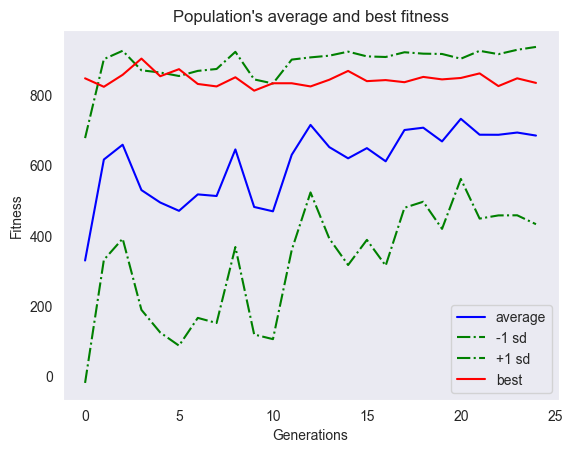

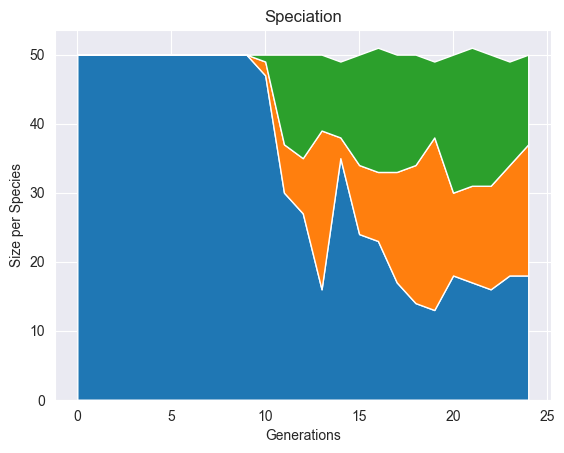

In [34]:
# visualize the best genome
node_names = {-1: 'player sum', -2: 'dealer sum', -3: 'Ass',  0: 'hit/stick'}
visualize.draw_net(config, winner, True, node_names=node_names)
visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=False)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

In [35]:
# test the best genome
from tqdm import tqdm

env = BlackjackEnv(sab=True)
n_episodes = 1000000
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

# For plotting metrics
timesteps_per_episode = []
wins = []

agent = neat.nn.FeedForwardNetwork.create(winner, config)

for i in tqdm(range(0, n_episodes)):
    
    state, info = env.reset()
    done = False
    
    while not done:
        action = agent.activate(state)
        #round action to 0 or 1
        action = neatHelpers.eval_action(action)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state

100%|██████████| 1000000/1000000 [01:01<00:00, 16343.66it/s]


In [38]:
win_rate = np.sum(np.array(env.return_queue).flatten() == 1) / len(env.return_queue)
print(win_rate)

0.407505


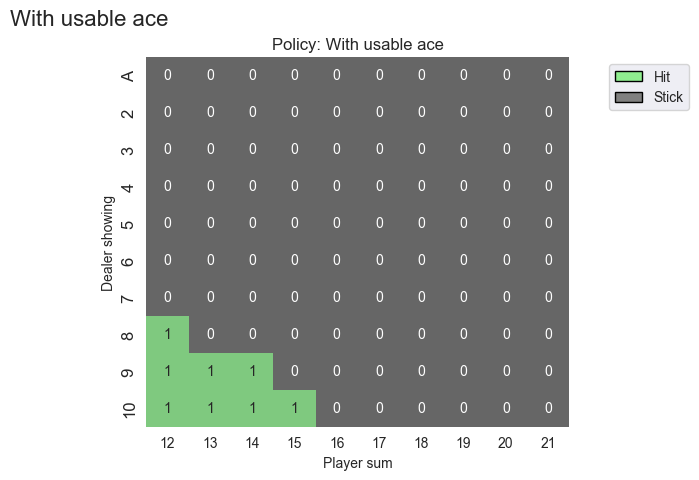

In [36]:
# plot policy matrix with ace
policy_grid = neatHelpers.create_grids(winner, config, usable_ace=True)
fig1 = neatHelpers.create_plots(policy_grid, title="With usable ace")
plt.show()

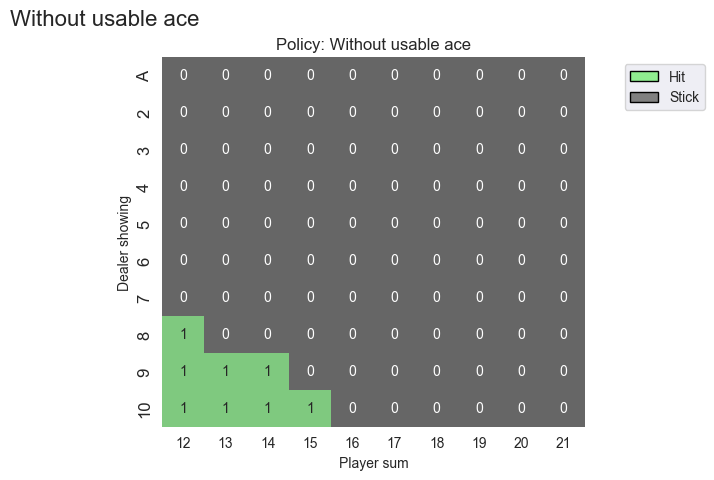

In [37]:
# plot policy matrix without ace
policy_grid = neatHelpers.create_grids(winner, config, usable_ace=True)
fig1 = neatHelpers.create_plots(policy_grid, title="Without usable ace")
plt.show()